<a href="https://colab.research.google.com/github/CeciliaKimura/time-series/blob/main/Time_Series_Forecasting_ARIMA_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting with ARIMA and SARIMA**

## Previsão do Preço da Soja


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importação das bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn as sk
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = 12, 7

Populating the interactive namespace from numpy and matplotlib


**Importação da base**

Utilizei a base Indicador da Soja CEPEA/ESALQ disponível em https://www.cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx

Essa base traz os preços em dólar e em real, optei por utilizar os valores em dólar para desconsiderar as oscilações cambiais.

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep= ';', decimal=",", header=0, index_col=0, parse_dates=True, squeeze=True)

In [4]:
dataset.head()

Data
2011-01-01    29.61
2011-02-01    29.54
2011-03-01    27.92
2011-04-01    27.98
2011-05-01    27.86
Name: Preco_Dolar, dtype: float64

In [5]:
type(dataset)

pandas.core.series.Series

In [6]:
dataset.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Data', length=120, freq=None)

Vamos plotar o gráfico para ter uma visão inicial da nossa série temporal.

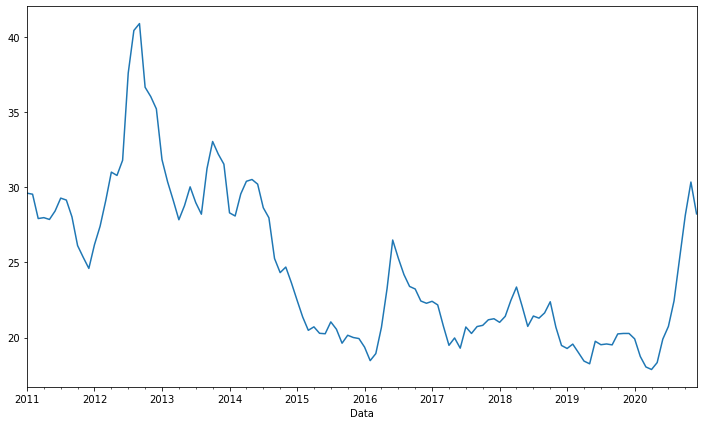

In [7]:
dataset.plot()

**Separar a base em treino e teste**

Vamos separar a base em treino e teste e depois a base de treino será separada em treino e validação.

*The **training set** is applied to train, or fit, your model. For example, you use the training set to find the optimal weights, or coefficients, for linear regression, logistic regression, or neural networks.* 

*The **validation se**t is used for unbiased model evaluation during hyperparameter tuning. For example, when you want to find the optimal number of neurons in a neural network or the best kernel for a support vector machine, you experiment with different values. For each considered setting of hyperparameters, you fit the model with the training set and assess its performance with the validation set.*

*The **test set** is needed for an unbiased evaluation of the final model. You
shouldn’t use it for fitting or validation.*

In [8]:
split_point = len(dataset) - 12

In [9]:
train = dataset[0:split_point]

In [10]:
test = dataset[split_point:]

In [11]:
print('train %d, val %d' % (len(train), len(test)))

train 108, val 12


In [12]:
test

Data
2020-01-01    19.91
2020-02-01    18.74
2020-03-01    18.04
2020-04-01    17.87
2020-05-01    18.33
2020-06-01    19.89
2020-07-01    20.74
2020-08-01    22.44
2020-09-01    25.30
2020-10-01    28.14
2020-11-01    30.35
2020-12-01    28.23
Name: Preco_Dolar, dtype: float64

In [13]:
train.to_csv('/content/drive/MyDrive/DGH/soja_train.csv')

In [14]:
test.to_csv('/content/drive/MyDrive/DGH/soja_test.csv')

**Análise de Dados**

In [15]:
series = pd.read_csv('/content/drive/MyDrive/DGH/soja_train.csv', sep=",",header=0, index_col=0, parse_dates=True, squeeze=True)

In [16]:
series.describe()

count    108.000000
mean      24.882870
std        5.248868
min       18.250000
25%       20.532500
50%       23.245000
75%       28.830000
max       40.900000
Name: Preco_Dolar, dtype: float64

In [17]:
series.head()

Data
2011-01-01    29.61
2011-02-01    29.54
2011-03-01    27.92
2011-04-01    27.98
2011-05-01    27.86
Name: Preco_Dolar, dtype: float64

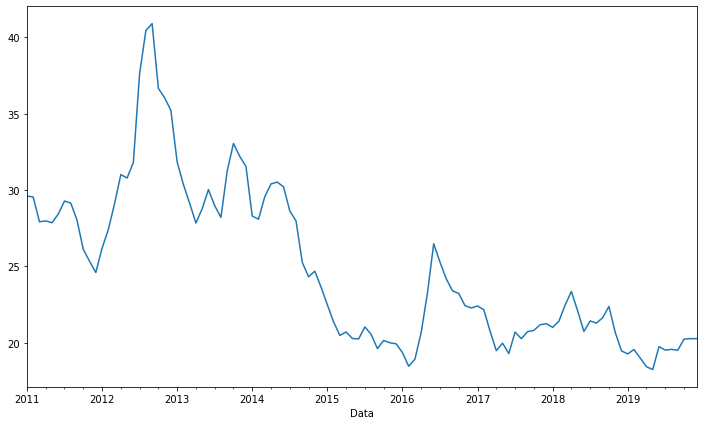

In [18]:
series.plot()

**Decomposição da série temporal**

In [19]:
import pandas.util.testing as tm
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao = seasonal_decompose(series, model='multiplicative')

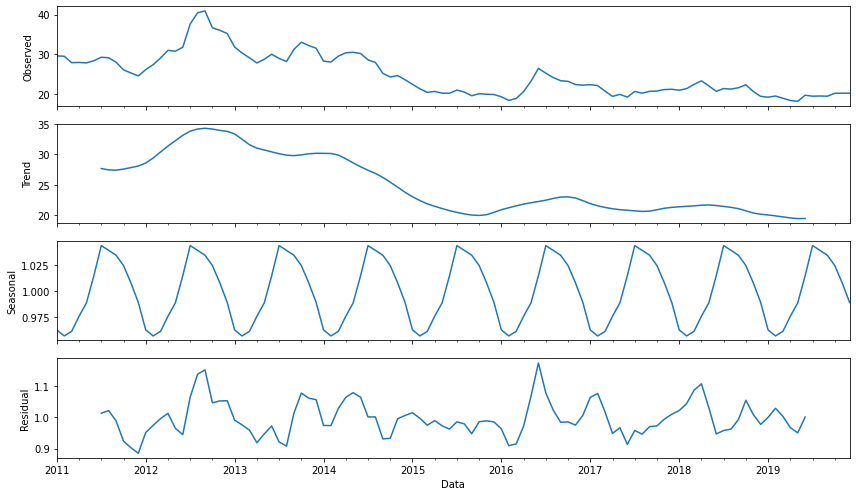

In [20]:
import matplotlib.pyplot as plt
decomposicao.plot()
pyplot.show()

**Verificar Sazonalidade**

In [21]:
from pandas import DataFrame
from pandas import Grouper

In [22]:
grupos = series['2010':'2019'].groupby(Grouper(freq='A'))
anos = DataFrame()
for nome, grupo in grupos:
  anos[nome.year] = grupo.values

In [23]:
anos

,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,29.61,26.18,31.84,28.30,22.49,19.36,22.41,21.01,19.27
1,29.54,27.41,30.36,28.09,21.37,18.46,22.17,21.41,19.56
2,27.92,29.11,29.13,29.56,20.48,18.93,20.77,22.47,19.00
3,27.98,31.01,27.84,30.40,20.71,20.68,19.48,23.36,18.43
4,27.86,30.79,28.78,30.52,20.28,23.26,19.97,22.09,18.25
5,28.42,31.80,30.03,30.21,20.25,26.49,19.29,20.74,19.75
6,29.28,37.61,28.98,28.64,21.04,25.28,20.70,21.43,19.52
7,29.15,40.44,28.21,27.97,20.55,24.19,20.27,21.29,19.57
8,28.03,40.90,31.25,25.26,19.62,23.40,20.73,21.64,19.51
9,26.12,36.66,33.05,24.32,20.15,23.23,20.81,22.38,20.24


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ac807d278>,
      dtype=object)

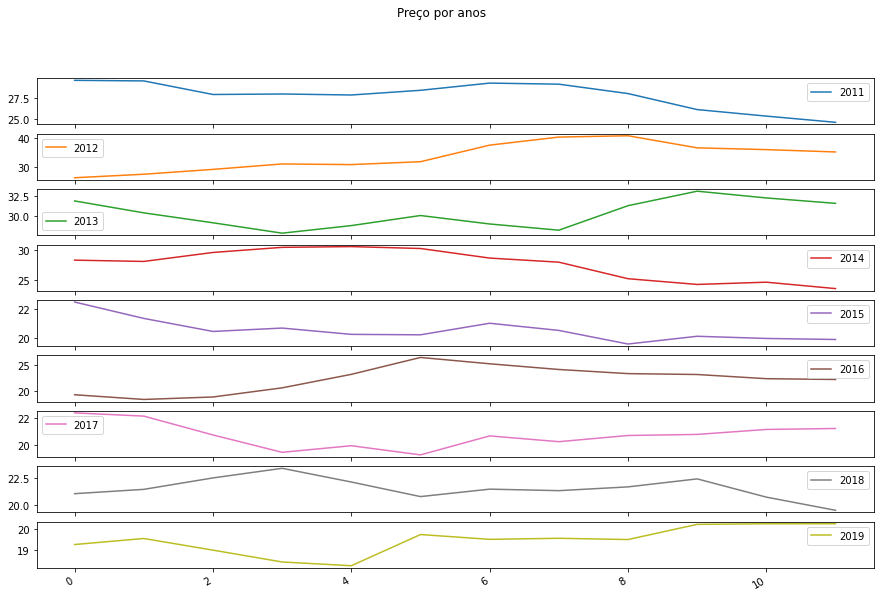

In [24]:
anos.plot(figsize=(15,10)
          ,subplots=True
          ,title='Preço por anos')

**Distribuição**

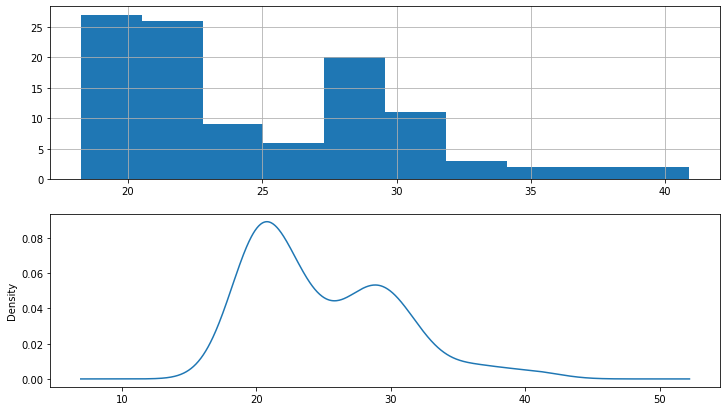

In [25]:
# Distribuição da Série
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

**Autocorrelação**

Autocorrelação significa a associação entre os valores de uma mesma variável, por exemplo. É comum quando os valores podem ser ordenados no tempo (com dados
de séries temporais) ou no espaço (com dados espaciais).

In [26]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

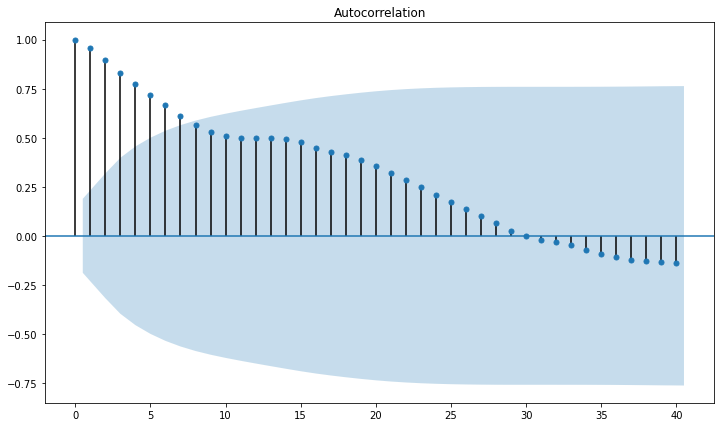

In [27]:
plot_acf(series, lags=40)
pyplot.show()

Até 7 lags ainda é observada autocorrelação significativa. Podemos usar essa informação para configuração de parâmetro nos modelos ARIMA e SARIMA.

**Estacionariedade**


Teste Estatístico - Augmented Dickey-Fuller test

Hipotese Nula (H0): Falha para rejeitar, sugere que a série não é estacionária. Esta tem estrutura dependente de tempo.

Hipotese Alternativa (H1): A hipotese nula foi rejeitada, sugere que a série temporal é estacionária. Esta não tem estrutura dependente de tempo.

p-value > 0.05: Falha para rejeitar a hipotese nula (h0) a série é não estacionária.

p-value ≤ 0.05: Rejeita a hipotese nula (H0), a série é estacionária.

In [28]:
import pandas.util.testing as tm
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(series.values)
print('\nADF teste: %f' % resultado[0])
print('\np-value: %f' % resultado[1])
print('\nCritical Values:')
for key, value in resultado[4].items():
  print('\t%s: %.3f' % (key, value))


ADF teste: -2.001544

p-value: 0.285896

Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


p > 0.05 portanto a série não é estacionária.


Aplicando a diferenciação para transformar a série em estacionária. 

O número de diferenciações necessárias para tornar uma série estacionária também é um parâmetro que pode ser configurado no ARIMA e SARIMA.

In [29]:
# cria uma lista chamada diff
diff = list()
mes = 1
for i in range(mes, len(series.values)):
  # a variavel valor recebe o valor da série atual menos o valor da série do mês anterior
  valor = series.values[i] - series.values[i - mes]
  # alimenta a lista diff
  diff.append(valor)

In [30]:
resultado = adfuller(diff)
print('\nADF teste: %f' % resultado[0])
print('\np-value: %f' % resultado[1])
print('\nCritical Values:')
for key, value in resultado[4].items():
  print('\t%s: %.3f' % (key, value))


ADF teste: -6.796476

p-value: 0.000000

Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


p < 0.05, rejeita H0, portanto a série diferenciada é estacionária

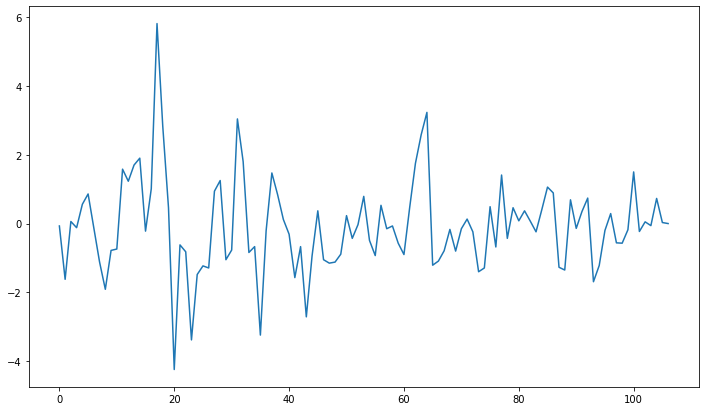

In [31]:
pyplot.plot(diff)
pyplot.show()

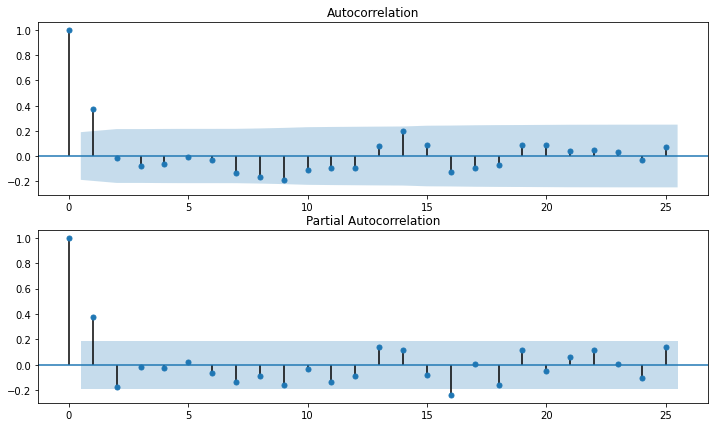

In [32]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(diff, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(diff, lags=25, ax=pyplot.gca())
pyplot.show()

A autocorrelação significativa agora é observada apenas em 1 lag.

**BASELINE**

Especificar uma baseline para base de comparação na avaliação do modelo.

Vamos usar na baseline o preço do período anterior para prever o preço atual.

In [33]:
# atribui os dados a variável X 
X = series.values

**Separar a base treino inicial em treino e validação**

In [34]:
# 2011-2017 treino, 2018-2019 validação
train_size = 60

In [35]:
# cria os conjuntos de treino e validação
train = X[0:train_size]
val = X[train_size:]

In [36]:
# armazenar os dados de treino em uma lista 
history = [x for x in train]

In [37]:
type(history)

list

In [38]:
# imprime o último valor da variável history
history[-1]

19.93

In [39]:
# cria uma lista para armazenar as precisões do modelo
predictions = list()

No nosso modelo do baseline o valor do mês anterior será considerado o valor predito.

In [40]:
# aplicando o modelo naive
for i in range(len(val)):
  
  # valor_predito recebe o último valor do conjunto de treino
  valor_predito = history[-1]
  
  # a primeira previsão é o último valor do conjunto de treino
  predictions.append(valor_predito)
  
  # valor real recebe o valor atual da base de validação
  valor_real = val[i]
  
  # adiciona o valor real para a lista de historico
  history.append(valor_real)
  
  # imprime valor predito e valor real
  print('Valor Predito=%.3f, Valor Esperado=%.3f' % (valor_predito, valor_real))

Valor Predito=19.930, Valor Esperado=19.360
Valor Predito=19.360, Valor Esperado=18.460
Valor Predito=18.460, Valor Esperado=18.930
Valor Predito=18.930, Valor Esperado=20.680
Valor Predito=20.680, Valor Esperado=23.260
Valor Predito=23.260, Valor Esperado=26.490
Valor Predito=26.490, Valor Esperado=25.280
Valor Predito=25.280, Valor Esperado=24.190
Valor Predito=24.190, Valor Esperado=23.400
Valor Predito=23.400, Valor Esperado=23.230
Valor Predito=23.230, Valor Esperado=22.430
Valor Predito=22.430, Valor Esperado=22.280
Valor Predito=22.280, Valor Esperado=22.410
Valor Predito=22.410, Valor Esperado=22.170
Valor Predito=22.170, Valor Esperado=20.770
Valor Predito=20.770, Valor Esperado=19.480
Valor Predito=19.480, Valor Esperado=19.970
Valor Predito=19.970, Valor Esperado=19.290
Valor Predito=19.290, Valor Esperado=20.700
Valor Predito=20.700, Valor Esperado=20.270
Valor Predito=20.270, Valor Esperado=20.730
Valor Predito=20.730, Valor Esperado=20.810
Valor Predito=20.810, Valor Espe

**Vamos usar como métrica de comparação o RMSE e o RMSLE**

Raiz do Erro Quadrático Médio (RMSE), é comumente usada para expressar a acurácia dos resultados numéricos com a vantagem de que RMSE apresenta valores do erro nas mesmas dimensões da variável analisada.

RMSLE considera o erro relativo entre os valores preditos e reais, não importando a escala do erro. A aplicação de logaritmos se dá no objetivo de evitar a penalização de diferenças elevadas entre valor predito e real quando ambos os valores são muito grandes. No caso do RMSE se a escala dos números é grande o RMSE é grande.


In [41]:
# avaliando o modelo naive
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(val, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 0.991


Esse erro significa que em média o modelo está errando US$ 0.99 na previsão dos preços da soja.

In [42]:
from sklearn.metrics import mean_squared_log_error

rmsle = np.sqrt(mean_squared_log_error(val, predictions))
print('RMSLE: %.3f' % rmsle)

RMSLE: 0.043


Esse erro significa que em média a diferença entre os valores previstos e reais é de 4.3%.

## **`ARIMA`**

Método estatístico que utiliza um modelo linear que utiliza autoregressão e modelo de média móvel para previsão de séries temporais. Um modelo linear é construído incluindo um número especificado de termos e o dado é preparado por um nível de diferenciação afim de tornar este estacionário.

Podemos usar um valor 0 para desligar um parâmetro, dessa forma, aquela função em questão não será feita, por exemplo, se no parâmetro d definirmos 0 não será realizada uma diferenciação nos dados. Neste exemplo teríamos um modelo **ARMA**.

*   **AR**: *Autoregression* : Um modelo que usa a relação dependende entre uma observação e alguns lags.

*   **I**: *Integrated*  : Uso de diferenciação nas observações brutas, exemplo: subtração do valor de uma observação com sua observação anterior. O objetivo é transformar a série temporal em estacionária.

*  **MA**: *Moving Average* : Um modelo que usa a dependência entre a observação e o erro residual a partir de um modelo de média móvel aplicado a lags.

**Parâmetros ARIMA(p,d,q)**

*   **p:** O número de lags que foram devem ser incluídos no modelo.
*   **d:** O número de vezes que as observações serão diferenciadas.
*   **q:** O tamanho de uma janela de média móvel. Também chamada de ordem de média móvel.

**SARIMA**

É uma extensão do ARIMA que suporta séries temporais univariadas com componente de sazonalidade.

**Elementos Sazonais**

*   P: Seasonal autoregressive order.
*   D: Seasonal difference order.
*   Q: Seasonal moving average order
*   m: The number of time steps for a single seasonal period. 

**Parâmetros SARIMA(p,d,q)(P,D,Q)m**


Como observado, existe sazonalidade na nossa série histórica portanto vamos utilizar o modelo SARIMA

In [43]:
import statsmodels.api as sm

**Tunning do SARIMA**

Vamos fazer um grid search para definir os melhores parâmetros, vamos usar o AIC como métrica de decisão.

*According Peterson, T. (2014) the AIC (Akaike Information Criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The lower AIC value the better.*

In [44]:
train = pd.read_csv('/content/drive/MyDrive/DGH/soja_train.csv', sep=",",header=0, index_col=0, parse_dates=True)
train.head()

,Preco_Dolar
Data,
2011-01-01,29.61
2011-02-01,29.54
2011-03-01,27.92
2011-04-01,27.98
2011-05-01,27.86


In [45]:
%%time
warnings.simplefilter('ignore')
import itertools

p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
m = 12 # considerando sazonalidade anual
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]

best_score, best_param, bestparam_seasonal = float("inf"), None, None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if abs(results.aic) < abs(best_score):
              best_score, best_param, bestparam_seasonal = results.aic, param, param_seasonal
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        print('Best SARIMA order%s Best SARIMA seazonal%s AIC=%.3f' % (best_param, bestparam_seasonal,best_score))


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:997.746514487744
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 0, 0, 12) AIC=997.747
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:802.7222812146465
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 0, 1, 12) AIC=802.722
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:689.99795606919
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 0, 2, 12) AIC=689.998
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:580.5780560892111
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 1, 0, 12) AIC=580.578
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:481.559997795299
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 1, 1, 12) AIC=481.560
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:3162.8577820386504
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 1, 1, 12) AIC=481.560
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:579.9936000161827
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 1, 1, 12) AIC=481.560
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:531.130666452652
Best SARIMA order(0, 0, 0) Best SARIMA seazonal(0, 1, 1, 12) AIC=481.

**Treinar o modelo SARIMA**

Vamos treinar o modelo com os parâmetros definidos no grid search

In [46]:
mod = sm.tsa.statespace.SARIMAX(train.loc[:'2017-12-01'],
                                order=(2, 1, 0),
                                seasonal_order=(2, 1, 1, 12))

sarima = mod.fit()

print(sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Preco_Dolar   No. Observations:                   84
Model:             SARIMAX(2, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -134.470
Date:                            Tue, 19 Jan 2021   AIC                            280.940
Time:                                    15:22:24   BIC                            294.516
Sample:                                01-01-2011   HQIC                           286.338
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3975      0.146      2.716      0.007       0.111       0.684
ar.L2         -0.1725      0.126   

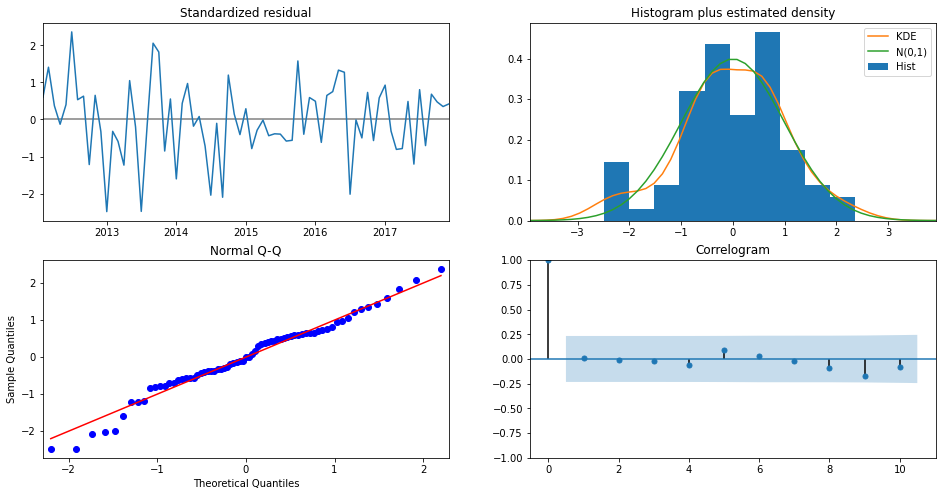

In [47]:
sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

Os resíduos estão dispersos aleatoriamente em
torno de zero, com variância constante, não apresentam padrão temporal indicando um bom ajuste do modelo. 

O histograma e a curva Q-Q demonstram que a distribuição dos resíduos se aproxima de uma curva normal, também indicando um bom ajuste do modelo.

Também podemos observar que não há autocorrelação nos resíduos indicando que os padrões temporais foram adequadamente modelados e não ficaram nos resíduos.

### **Validação**

**Holdout (78/22)**

78% dos valores para treino e 22% para teste, no caso 2011-2017 e 2018-1019 respectivamente.

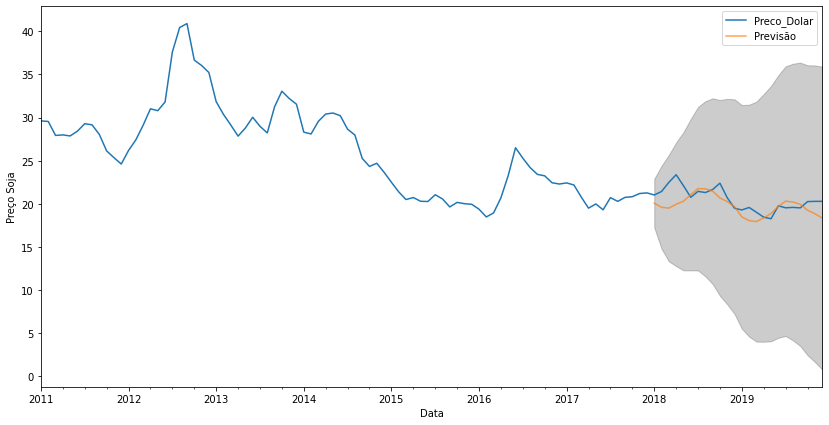

In [48]:
pred = sarima.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2019-12-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = train['2011':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Preço Soja')
plt.legend()

plt.show()

*Prediction intervals are calculated by performing multiple simulations (1000 by default) and using the percentiles of the simulation results. This is done internally by the get_prediction method. https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html*

In [49]:
y_forecasted = pred.predicted_mean
y_truth = train['2018-01-01':]

rmsle = np.sqrt(mean_squared_log_error(y_truth, y_forecasted))
print('RMSLE: %.3f' % rmsle)

RMSLE: 0.063


O erro entre os valores preditos e reais foi de 6.3%

**Prequencial Sliding**

Vamos criar uma janela deslizante para validar os dados. Fizemos o ano anterior para treino e o ano para validação. Depois calculamos a média do erro para esses diversos períodos de treino e validação.

In [50]:
treino = pd.read_csv('/content/drive/MyDrive/DGH/soja_train.csv', sep=",",header=0, index_col=0, parse_dates=True)

In [51]:
treino['Data'] = pd.to_datetime(treino.index)

In [52]:
treino['ano'] = treino['Data'].dt.year

In [53]:
treino.index = treino['Data']

In [54]:
train

,Preco_Dolar
Data,
2011-01-01,29.61
2011-02-01,29.54
2011-03-01,27.92
2011-04-01,27.98
2011-05-01,27.86
...,...
2019-08-01,19.57
2019-09-01,19.51
2019-10-01,20.24


In [55]:
%%time
from sklearn.metrics import mean_squared_log_error

results_val = []

for ano in range(2012,2020):
    print("Train ano {} - Validation ano {}".format(ano - 1, ano))
    

    train = treino[treino['ano'] == ano-1]
    val = treino[treino['ano'] == ano]

    train = train.drop(['ano', 'Data'], axis=1)
    
    X_train = train.index
    X_val = val.index

    y_train = train['Preco_Dolar']
    y_val = val['Preco_Dolar']
     

    mod = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 0), seasonal_order=(2, 1, 1, 1))

    results = mod.fit()

    predictions = results.forecast(12)
    rmsle = np.sqrt(mean_squared_log_error(y_val, predictions))
    #print(correlation)
    
    results_val.append(rmsle)
    print("RMSLE {}".format(rmsle))
    print()


Train ano 2011 - Validation ano 2012
RMSLE 0.36936336856881963

Train ano 2012 - Validation ano 2013
RMSLE 0.16385433728973142

Train ano 2013 - Validation ano 2014
RMSLE 0.2718558992855543

Train ano 2014 - Validation ano 2015
RMSLE 0.06978847652479192

Train ano 2015 - Validation ano 2016
RMSLE 0.132289643390751

Train ano 2016 - Validation ano 2017
RMSLE 0.1591839162240581

Train ano 2017 - Validation ano 2018
RMSLE 0.049747651623039214

Train ano 2018 - Validation ano 2019
RMSLE 0.07657084495915835

CPU times: user 2.27 s, sys: 1.66 s, total: 3.93 s
Wall time: 2.15 s


In [56]:
np.median(results_val)

0.14573677980740454

O erro médio calculado por esse método é de 14.57%.

**Testar na amostra de teste**

Vamos avaliar se o modelo apresenta uma performance semelhante na base teste (2020). 

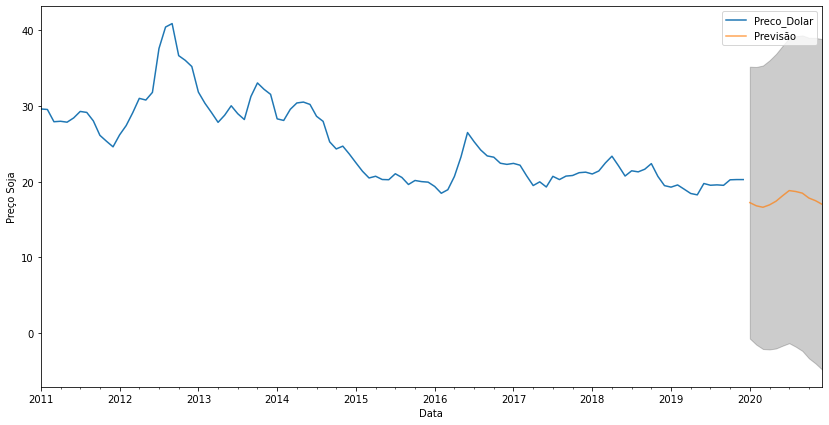

RMSLE: 0.271


In [57]:
train = pd.read_csv('/content/drive/MyDrive/DGH/soja_train.csv', sep=",",header=0, index_col=0, parse_dates=True)
test = pd.read_csv('/content/drive/MyDrive/DGH/soja_test.csv', sep=",",header=0, index_col=0, parse_dates=True)

pred = sarima.get_prediction(start=pd.to_datetime('2020-01-01'), end=pd.to_datetime('2020-12-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = train['2011':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Preço Soja')
plt.legend()

plt.show()


y_forecasted = pred.predicted_mean
y_test = test['Preco_Dolar']

rmsle = np.sqrt(mean_squared_log_error(y_test, y_forecasted))
print('RMSLE: %.3f' % rmsle)

O erro (27.1%) foi bem maior que o esperado, tanto na validação 'holdout' quando na 'prequencial sliding' indicando que o ano de 2020 não apresentou o comportamento modelado pelos anos anteriores.

In [58]:
ytest = test['Preco_Dolar'].reset_index(drop=True)
ytest

0     19.91
1     18.74
2     18.04
3     17.87
4     18.33
5     19.89
6     20.74
7     22.44
8     25.30
9     28.14
10    30.35
11    28.23
Name: Preco_Dolar, dtype: float64

In [59]:
y_forecasted.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

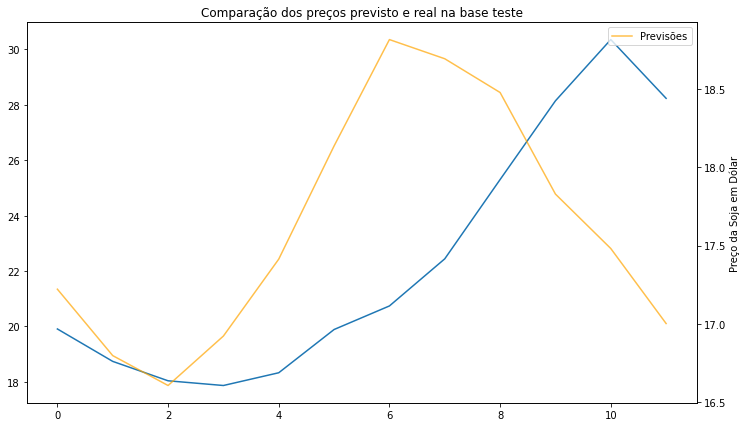

In [60]:
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(y_forecasted.values, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

Apesar do modelo não estar bom, vamos fazer o forecast para 2021 usando o dataset completo para treinar o modelo, apenas para demonstrar como seria o processo completo.

## **Forecast**

**Retreinar o modelo**

Incluir todos os dados para retreinar o modelo e fazer o forecast do próximo ano

In [61]:
mod = sm.tsa.statespace.SARIMAX(dataset,
                                order=(2, 1, 0),
                                seasonal_order=(2, 1, 1, 12))

sarima = mod.fit()

print(sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Preco_Dolar   No. Observations:                  120
Model:             SARIMAX(2, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -190.075
Date:                            Tue, 19 Jan 2021   AIC                            392.150
Time:                                    15:22:31   BIC                            408.187
Sample:                                01-01-2011   HQIC                           398.652
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4669      0.112      4.173      0.000       0.248       0.686
ar.L2         -0.1890      0.105   

**Criar um "Out-of-Sample Forecast"**

Vamos prever 12 passos, no nosso caso meses, para frente dos nossos dados, ou seja vamos fazer a previsão para 2021.

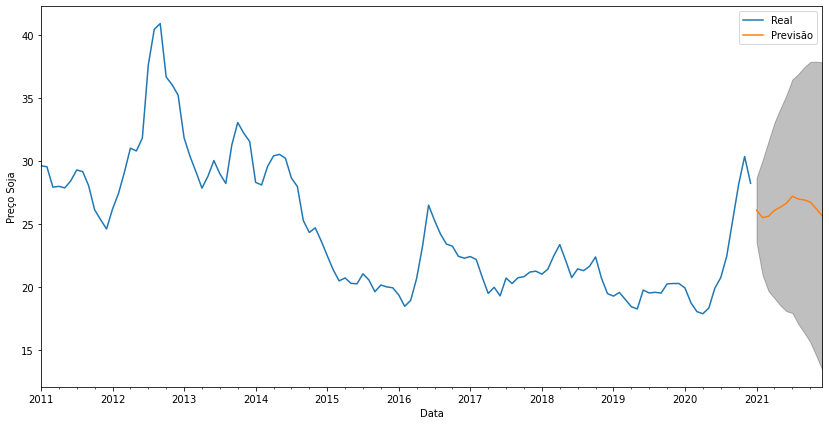

In [62]:
pred_uc = sarima.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

ax = dataset.plot(label='Real', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Preço Soja')

plt.legend()
plt.show()


In [63]:
pred_uc.predicted_mean, pred_ci

(2021-01-01    26.091603
 2021-02-01    25.499082
 2021-03-01    25.606606
 2021-04-01    26.073015
 2021-05-01    26.337257
 2021-06-01    26.638389
 2021-07-01    27.196382
 2021-08-01    26.975871
 2021-09-01    26.903267
 2021-10-01    26.735841
 2021-11-01    26.216874
 2021-12-01    25.635587
 Freq: MS, dtype: float64,             lower Preco_Dolar  upper Preco_Dolar
 2021-01-01          23.529119          28.654088
 2021-02-01          20.955618          30.042545
 2021-03-01          19.666759          31.546453
 2021-04-01          19.109168          33.036863
 2021-05-01          18.529007          34.145507
 2021-06-01          18.073514          35.203264
 2021-07-01          17.931235          36.461528
 2021-08-01          17.056679          36.895063
 2021-09-01          16.370055          37.436478
 2021-10-01          15.622662          37.849021
 2021-11-01          14.552523          37.881225
 2021-12-01          13.445080          37.826093)

Os próximos passas seriam retreinar o modelo a cada novo dado e ir verificando se o modelo está prevendo os dados de acordo com o esperado.

No caso de séries temporais o mais importante é que o modelo esteja acertando a incerteza que o valor em si.

Neste caso, a incerteza está grande, o ideal é que o modelo tenha uma incerteza pequena e acerte dentro dessa incerteza.